Let's ask some question Billy Beane and Paul DePodesta, probably, asked when they tried to achieve their goals. The first question is:

1. **What's the key goal to our team?** - to promote to playoffs. Not to win the division or World Series. Just to play good during the 165-games regular season to make it to playoffs

So, the second one:
2. **How does the team promote to playoffs?**
Scatter plot helps to answer this question

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm

In [5]:
# Load data
data = pd.read_csv('baseball_processed.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      902 non-null    object 
 1   League    902 non-null    object 
 2   Year      902 non-null    int64  
 3   RS        902 non-null    int64  
 4   RA        902 non-null    int64  
 5   W         902 non-null    int64  
 6   OBP       902 non-null    float64
 7   SLG       902 non-null    float64
 8   BA        902 non-null    float64
 9   Playoffs  902 non-null    int64  
 10  G         902 non-null    int64  
 11  OOBP      902 non-null    float64
 12  OSLG      902 non-null    float64
dtypes: float64(5), int64(6), object(2)
memory usage: 91.7+ KB


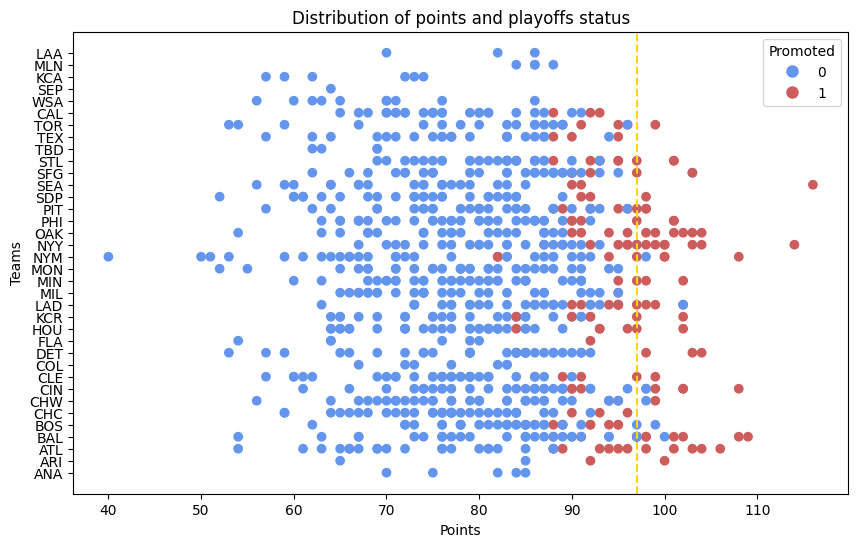

In [32]:
# Plot the wins required to go to playoff
x = data.W
y = data.Team

# Choose colors to dived promotion status
categories = data.Playoffs.to_list()
color_map = {0: 'cornflowerblue', 1: 'indianred'}
colors = [color_map[cat] for cat in categories]

# Plot and save figure
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors)
plt.xlabel('Points')
plt.ylabel('Teams')
plt.title('Distribution of points and playoffs status')

# Plot the threshold of wins to promote to playoffs (keep reading to understand)
plt.axvline(97, linestyle='--', c='gold', label='Wins threshold')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in color_map.values()]
plt.legend(handles, color_map.keys(), title="Promoted")
plt.savefig('Distribution of points and playoffs status.png')
plt.show()

In [9]:
# Let's look at most common amount of points needed to promote to playoffs
a = data[['W', 'Playoffs']]
a = a[a.Playoffs != 0]
wins_to_playoff = a.W.value_counts()
df_wtp = wins_to_playoff.to_frame().reset_index()
df_wtp.head()

,W,count
0,95,15
1,97,13
2,90,12
3,98,11
4,92,11


In [10]:
# Build simple logistics regression to define the threshold of wins to promotion
win_prob_model = LogisticRegression()
wins = pd.DataFrame(data.W)
binary_playoffs = data.Playoffs
win_prob_model.fit(wins, binary_playoffs)

LogisticRegression()

In [11]:
# Concatenate probabilities with the sorted points to DF
points = np.sort(df_wtp.W.to_numpy())
prob = win_prob_model.predict_proba(points.reshape(-1, 1))[:, 1]

# Write it to dataframe
prob_distribution = pd.DataFrame({
    'points': points,
    'prob': np.round(prob, 2)
})
prob_distribution.sort_values('prob', ascending=False).head(15)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,points,prob
25,114,1.00
24,109,1.00
26,116,1.00
22,106,0.99
23,108,0.99
21,104,0.98
20,103,0.97
19,102,0.96
18,101,0.94
17,100,0.92


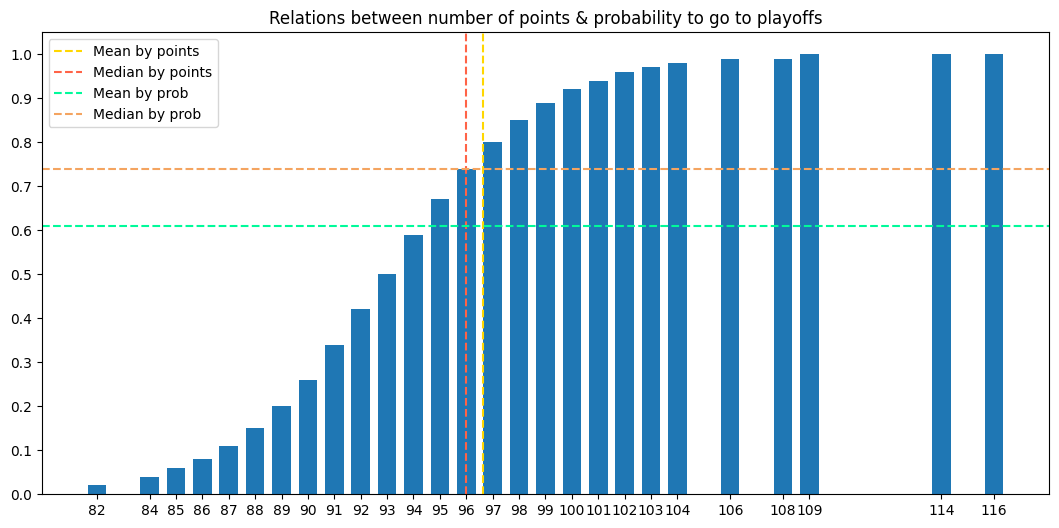

In [14]:
# Plot the distribution of points and probability of playoff promotion

# Calculate central tendency metrics
mean_points = np.mean(prob_distribution.points)
median_points = np.quantile(prob_distribution.points, 0.5)
mean_prob = np.mean(prob_distribution.prob)
median_prob = np.median(prob_distribution.prob)

# Plot lines
plt.figure(figsize=(13, 6))
plt.axvline(mean_points,
            linestyle='--',
            c='gold',
            label='Mean by points'
            )
plt.axvline(median_points,
            linestyle='--',
            c='tomato',
            label='Median by points'
            )
plt.axhline(mean_prob,
            linestyle='--',
            c='mediumspringgreen',
            label='Mean by prob'
            )
plt.axhline(median_prob,
            linestyle='--',
            c='sandybrown',
            label='Median by prob'
            )

# Plot and save figure
plt.bar(prob_distribution.points, prob_distribution.prob, width=0.7)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(points)
plt.title('Relations between number of points & probability to go to playoffs')
plt.legend()
plt.savefig('Number of points based on playoff promotion chance.png')
plt.show()

*As you can see on graphic, there are mean and median values of points and playoffs probability promotion. And if we compare it with distributions DataFrame we can see that 95 points will give the team only 67% probability to promote to playoffs, but if the team get 2 more points (97), then the team will have 80% chance to play there (+13%). Let's set our threshold to **97 points to get to playoffs**.*

P.s. go back to scatter plot and show the threshold line

I defined the treshold of wins the team should overcome to make to playoffs. So the next question is:
3. **How to win more games?**
Obvious answer - score more runs in terms of baseball. Let's concrete this:

**How many more runs team should score to go to playoffs?**

In [15]:
# Let's add the difference between Runs Allowed and Runs Scored and name it RD
data['RD'] = data.RS - data.RA
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG,RD
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,162,0.331,0.412,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,162,0.311,0.404,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,162,0.314,0.384,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,162,0.337,0.439,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,161,0.329,0.393,27


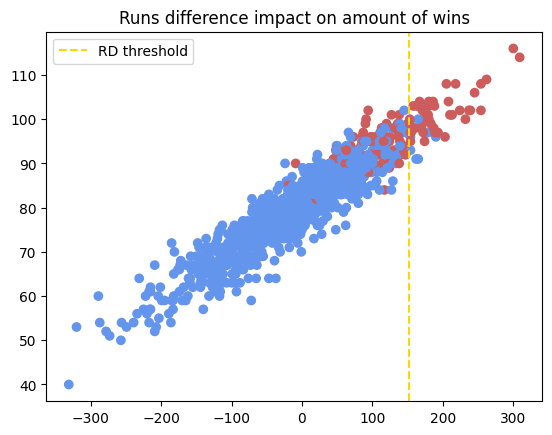

In [36]:
# Let's plot the connection between wins and runs difference
x = data.RD
y = data.W

plt.scatter(x, y, c=colors)

# Plot the threshold of runs difference to promote to playoffs
plt.axvline(152, linestyle='--', c='gold',
            label='RD threshold')  # continue reading to understand
plt.title('Runs difference impact on amount of wins')
plt.legend()
plt.savefig('Runs difference impact on amount of wins.png')
plt.show()

The next things is to make a simple linear regression to define how many more runs team should score

In [37]:
# Build a simple linear regression
model = LinearRegression()
X = pd.DataFrame(data.RD)
y = pd.DataFrame(data.W)
model.fit(X, y)

LinearRegression()

In [38]:
# Get the coefficient and intercept
intercept = float(np.round(model.intercept_, 4))
RD = float(np.round(model.coef_, 4))

print(intercept, RD)

80.8814 0.1058


/tmp/ipython-input-38-678146841.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(np.round(model.intercept_, 4))
/tmp/ipython-input-38-678146841.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RD = float(np.round(model.coef_, 4))


In [39]:
# Write our equation to calculate how many more runs the team should score
target_wins_amount = 97
more_runs = int((target_wins_amount - intercept) / RD)
more_runs

152

Write our equation in LaTeX:

\begin{align*}
W &= 80.8814 + 0.1058 \times RD \\
RD &= \frac{W - 80.8814}{0.1058} \\
RD &= \frac{97 - 80.8814}{0.1058} \\
RD &\approx 152
\end{align*}

The team should score **152 more runs**

The fourth question is:
4. **How does the team score 152 more runs?**

As you can see in the previous notebook: OBP, SLG and BA are heavily connected with number of wins. There are more stats that impact on the amount of wins, but we have some constraints: dataset contains only these three metrics. So, I will use them to build regression model

In [44]:
# Model with Batting average
offensive_metrics = data[['OBP', 'SLG', 'BA']]
runs_to_predict = data[['RS']]

# Get summary
offensive_metrics = sm.add_constant(offensive_metrics)
mlr = sm.OLS(runs_to_predict, offensive_metrics).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3989.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:40:06   Log-Likelihood:                -4170.2
No. Observations:                 902   AIC:                             8348.
Df Residuals:                     898   BIC:                             8368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -788.4570     19.697    -40.029      0.0

In [45]:
# Model without Batting average
offensive_metrics_wba = data[['OBP', 'SLG']]
runs_to_predict = data[['RS']]

# Get summary
offensive_metrics_wba = sm.add_constant(offensive_metrics_wba)
mlr = sm.OLS(runs_to_predict, offensive_metrics_wba).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:40:08   Log-Likelihood:                -4174.2
No. Observations:                 902   AIC:                             8354.
Df Residuals:                     899   BIC:                             8369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -804.6271     18.921    -42.526      0.0

As you can see, combination of OBP and SLG clearly explain target variable based on adjusted R2 score. So, as Beane and Podesta did, I will focus on that combination

The last but not least question manager and his assistant asked:

**5. What OBP and SLG does the team need to achieve the +152 runs**

In [46]:
# Build another model to get the prediction of runs allowed using OOBP and OSLG
metrics = data[['OSLG', 'OOBP']]
ra_to_predict = data['RA']

# Print summary
oobp_oslg = sm.add_constant(metrics)
runs_allowed_model = sm.OLS(ra_to_predict, oobp_oslg).fit()
print(runs_allowed_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     RA   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     34.19
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           4.87e-15
Time:                        12:40:15   Log-Likelihood:                -5342.3
No. Observations:                 902   AIC:                         1.069e+04
Df Residuals:                     899   BIC:                         1.071e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -909.7613    212.330     -4.285      0.0

In [47]:
# Get model parameters to calculate regression equation
const, OOBP_coef, OSLG_coef = runs_allowed_model.params.iloc[0], runs_allowed_model.params.iloc[1], runs_allowed_model.params.iloc[2]

vars = list([const, OOBP_coef, OSLG_coef])
vars_rounded = list(map(lambda x: round(x, 2), vars))

# Let's look at Oakland Athletics 2001 performance
year_2001 = data[data.Year == 2001]
athletics_2001 = year_2001[year_2001.Team == 'OAK']
oak_oobp_oslg = athletics_2001[['OOBP', 'OSLG']]

In [48]:
# Calculate values
coef = oak_oobp_oslg.loc[20, 'OOBP']
coef_2 = oak_oobp_oslg.loc[20, 'OSLG']
RA_pred = const + (OOBP_coef * coef) + (OSLG_coef * coef_2)
print('Runs allowed predicted in the 2002 season: {:.0f}'.format(RA_pred))

Runs allowed predicted in the 2002 season: 586


In [49]:
# How many runs the team need to score?
RA_pred = int(round(RA_pred, 0))
runs_to_score = RA_pred + more_runs
print('OAK needs {} runs to score in 2002 to get to playoffs based on predicted RA.'.format(runs_to_score))

OAK needs 738 runs to score in 2002 to get to playoffs based on predicted RA.


In [52]:
# Runs allowed predict vs Runs allowed real
# I need to upload dataset of 2002 year
data_2002 = pd.read_csv('year_2002.csv')
data_2002.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ANA,AL,2002,851,644,99,0.341,0.433,0.282,1,162,0.314,0.392
1,ARI,NL,2002,819,674,98,0.346,0.423,0.267,1,162,0.305,0.397
2,ATL,NL,2002,708,565,101,0.331,0.409,0.260,1,161,0.313,0.364
3,BAL,AL,2002,667,773,67,0.309,0.403,0.246,0,162,0.336,0.435
4,BOS,AL,2002,859,665,93,0.345,0.444,0.277,0,162,0.308,0.385


Check the website for more info of [2002 season](https://www.baseball-reference.com/teams/OAK/2002.shtml)

In [53]:
# Get the OAK metrics from 2002
oak = data_2002[data_2002.Team == 'OAK']
obp, slg, oobp, oslg = oak.loc[20, 'OBP'], oak.loc[20, 'SLG'], oak.loc[20, 'OOBP'], oak.loc[20, 'OSLG']

# Calculate runs allowed in 2002 and compare with actual value
reg_equation = int(np.round(const + (OOBP_coef * oobp) + (OSLG_coef * oslg), 0))

print(f'Predicted runs allowed in 2002 is {reg_equation}. Actual value is 654')

Predicted runs allowed in 2002 is 608. Actual value is 654


In [54]:
rs_intercept = mlr.params.iloc[0]
rs_coef = mlr.params.iloc[1]
rs_coef_1 = mlr.params.iloc[2]

rs_equation = int(np.round(rs_intercept + (rs_coef * obp) + (rs_coef_1 * slg), 0))
print(f'Predicted runs allowed in 2002 is {rs_equation}. Actual value is 800')

Predicted runs allowed in 2002 is 808. Actual value is 800


In [55]:
# Calculate diffrenece
rd_predicted = rs_equation - reg_equation

# Predict the number of wins using original equation
wins_pred = int(np.round(intercept + RD * rd_predicted, 0))

print(f'Runs difference predicted: {rd_predicted}, wins predicted: {wins_pred}')

Runs difference predicted: 200, wins predicted: 102


Let's compare with the real results

In [57]:
resulted_df = pd.DataFrame({
    'predicted': [rs_equation, reg_equation, rd_predicted, wins_pred],
    'real_nums': [800, 654, 800 - 654, 103]
}, index=['RS', 'RA', 'RD', 'W'])

resulted_df['difference'] = np.abs(resulted_df.predicted - resulted_df.real_nums)
resulted_df

# Save the results
resulted_df.to_csv('results.csv')

Despite the fact that there are only 900+ entries in the dataset the goal was achieved and I could almost predict the real number of wins, show relations between metrics and train some techinal skills. That's a good dataset to learn the data-driven approach and the art of asking questions to data. Anyway, I still should sharpen my mathematical skills and using ML algorithms to deepen the understanding of data :)